# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [2]:
newdata = data.tail(40000)
newdata.sort_values(by=['Time_formatted'], inplace=True)

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y_40k = newdata['Score'].values
X_no_stop_40k = newdata['New_Text'].values
X_summary_40k = newdata ['Summary'].values

X_no_stop_train_40k, X_no_stop_test_40k, y_train_40k, y_test_40k = train_test_split(X_no_stop_40k, Y_40k, test_size=0.33, shuffle=False)



## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [4]:
%time
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=9000)
bow_X_train_no_stop_40k = bow_vect.fit_transform(X_no_stop_train_40k)
bow_X_test_no_stop_40k = bow_vect.transform(X_no_stop_test_40k)
##################################################
###############################################
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score




Wall time: 0 ns


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500,1000]}
grid_DT_BOW = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),param_grid,scoring='roc_auc',cv=10, verbose=2)
grid_DT_BOW.fit(bow_X_train_no_stop_40k,y_train_40k)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] m

[CV] ....................... max_depth=5, min_samples_split=5 -   0.2s
[CV] max_depth=5, min_samples_split=5 ................................
[CV] ....................... max_depth=5, min_samples_split=5 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ...................... max_depth=5, min_samples_split=10 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ...................... max_depth=5, min_samples_split=10 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ...................... max_depth=5, min_samples_split=10 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ...................... max_depth=5, min_samples_split=10 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ...................... max_depth=5, min_samples_split=10 -   0.2s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] .

[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ..................... max_depth=10, min_samples_split=10 -   1.0s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ..................... max_depth=10, min_samples_split=10 -   1.0s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ..................... max_depth=10, min_samples_split=10 -   1.0s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ..................... max_depth=10, min_samples_split=10 -   1.0s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .................... max_depth=10, min_samples_split=100 -   0.8s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .................... max_depth=10, min_samples_split=100 -   0.7s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .................... max_depth=10, min_samples_split=100 -   0.7s
[CV] m

[CV] .................... max_depth=50, min_samples_split=100 -   3.7s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   3.7s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   3.8s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   3.9s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   4.0s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   3.7s
[CV] max_depth=50, min_samples_split=100 .............................
[CV] .................... max_depth=50, min_samples_split=100 -   3.8s
[CV] max_depth=50, min_samples_split=500 .............................
[CV] .

[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.5s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.6s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.5s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.5s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.7s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.5s
[CV] max_depth=100, min_samples_split=500 ............................
[CV] ................... max_depth=100, min_samples_split=500 -   3.4s
[CV] m

[CV] ................... max_depth=500, min_samples_split=500 -   4.9s
[CV] max_depth=500, min_samples_split=500 ............................
[CV] ................... max_depth=500, min_samples_split=500 -   4.9s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .................. max_depth=500, min_samples_split=1000 -   2.1s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .................. max_depth=500, min_samples_split=1000 -   2.3s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .................. max_depth=500, min_samples_split=1000 -   2.3s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .................. max_depth=500, min_samples_split=1000 -   2.1s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .................. max_depth=500, min_samples_split=1000 -   2.4s
[CV] max_depth=500, min_samples_split=1000 ...........................
[CV] .

[CV] max_depth=1000, min_samples_split=1000 ..........................
[CV] ................. max_depth=1000, min_samples_split=1000 -   2.2s
[CV] max_depth=1000, min_samples_split=1000 ..........................
[CV] ................. max_depth=1000, min_samples_split=1000 -   2.0s
[CV] max_depth=1000, min_samples_split=1000 ..........................
[CV] ................. max_depth=1000, min_samples_split=1000 -   2.4s
[CV] max_depth=1000, min_samples_split=1000 ..........................
[CV] ................. max_depth=1000, min_samples_split=1000 -   2.1s


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed: 18.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [7]:
grid_DT_BOW.best_params_

{'max_depth': 50, 'min_samples_split': 1000}

In [8]:
besthyperpara_bow_DT = DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=1000,class_weight='balanced')
besthyperpara_bow_DT.fit(bow_X_train_no_stop_40k,y_train_40k)
pred_proba_train_bow_DT=(besthyperpara_bow_DT.predict_proba(bow_X_train_no_stop_40k)[:,1])
pred_proba_test_bow_DT=(besthyperpara_bow_DT.predict_proba(bow_X_test_no_stop_40k)[:,1])
roc_auc_test_bow_DT_= (roc_auc_score(y_test_40k,pred_proba_test_bow_DT))
roc_auc_train_bow_DT  = (roc_auc_score(y_train_40k,pred_proba_train_bow_DT))


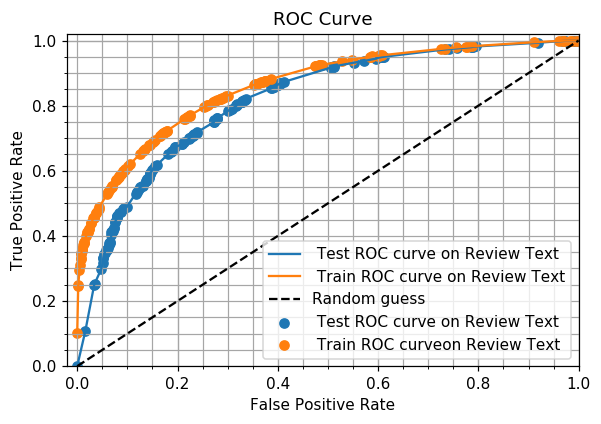

In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_DT, tpr_test_bow_DT, thresholds = roc_curve(y_test_40k, pred_proba_test_bow_DT)
fpr_train_bow_DT, tpr_train_bow_DT, thresholds = roc_curve(y_train_40k, pred_proba_train_bow_DT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_DT, tpr_test_bow_DT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_DT, tpr_test_bow_DT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_DT, tpr_train_bow_DT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_DT, tpr_train_bow_DT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [11]:
from sklearn.metrics import roc_auc_score
predict_DT_BOW_train = (grid_DT_BOW.predict(bow_X_train_no_stop_40k))
predict_DT_BOW_test = grid_DT_BOW.predict(bow_X_test_no_stop_40k)

roc_auc_DT_BOW_train = roc_auc_score(y_test_40k, predict_DT_BOW_test)
roc_auc_DT_BOW_test = roc_auc_score(y_train_40k, predict_DT_BOW_train)



In [12]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_DT_BOW_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_DT_BOW_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.37      0.73      0.49      2156
          1       0.93      0.76      0.84     11044

avg / total       0.84      0.76      0.78     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.43      0.81      0.56      4707
          1       0.95      0.77      0.85     22093

avg / total       0.86      0.78      0.80     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


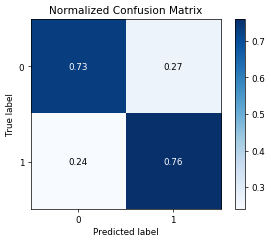

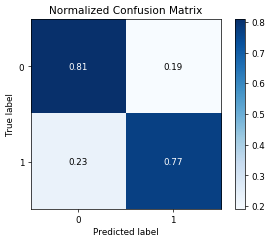

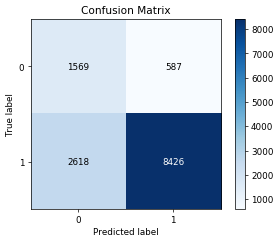

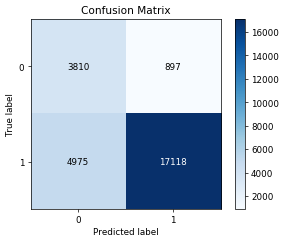

In [14]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_DT_BOW_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_DT_BOW_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_DT_BOW_test)
skplt.plot_confusion_matrix(y_train_40k, predict_DT_BOW_train)


### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [78]:
# https://github.com/Manish-12/Decision-Tree-on-Amazon-fine-food-reviews/blob/master/Decision_tree.ipynb
top_20_feature_bow = besthyperpara_bow_DT.feature_importances_.argsort()[::-1][:20]
below_20_feature_bow = besthyperpara_bow_DT.feature_importances_.argsort()[::-1][20:]

print(np.take(bow_vect.get_feature_names(),top_20_feature_bow))

['not' 'great' 'best' 'love' 'disappointed' 'good' 'perfect' 'bad'
 'delicious' 'nice' 'loves' 'excellent' 'favorite' 'happy' 'easy'
 'wonderful' 'money' 'highly recommend' 'not good' 'thought']


In [79]:
print(np.take(bow_vect.get_feature_names(),below_20_feature_bow))

['waste' 'return' 'lov' ... 'pills' 'pinch' '10']


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

Lets reduce the depth till 5 for Graphviz

In [98]:
besthyperpara_bow_DT_depth5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=1000,class_weight='balanced')
besthyperpara_bow_DT_depth5.fit(bow_X_train_no_stop_40k,y_train_40k)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [99]:
#https://pythonprogramminglanguage.com/decision-tree-visual-example/

from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(besthyperpara_bow_DT_depth5,feature_names =bow_vect.get_feature_names() ,out_file='tree_nonlimited.dot')


In [103]:
from IPython.display import Image
Image(filename = r'C:\Users\Prateek Saurabh\AppliedAI\Homework and assignments\tree_nonlimited.png')

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 7,max_features=5000)
tfidf_X_train = tf_idf_vect.fit_transform(X_no_stop_train_40k)
tfidf_X_test = tf_idf_vect.transform(X_no_stop_test_40k)


In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500,1000]}
grid_DT_tfidf = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_DT_tfidf.fit(tfidf_X_train,y_train_40k)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] m

[CV] ................... max_depth=50, min_samples_split=1000 -   1.5s
[CV] max_depth=50, min_samples_split=1000 ............................
[CV] ................... max_depth=50, min_samples_split=1000 -   1.8s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   4.5s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   4.5s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   4.4s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   4.3s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   4.3s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [53]:
grid_DT_tfidf.best_params_

{'max_depth': 50, 'min_samples_split': 1000}

In [55]:
besthyperpara_tfidf_DT = DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=1000,class_weight='balanced')
besthyperpara_tfidf_DT.fit(tfidf_X_train,y_train_40k)
pred_proba_train_tfidf_DT=(besthyperpara_tfidf_DT.predict_proba(tfidf_X_train)[:,1])
pred_proba_test_tfidf_DT=(besthyperpara_tfidf_DT.predict_proba(tfidf_X_test)[:,1])
roc_auc_test_tfidf_DT_= (roc_auc_score(y_test_40k,pred_proba_test_tfidf_DT))
roc_auc_train_tfidf_DT  = (roc_auc_score(y_train_40k,pred_proba_train_tfidf_DT))


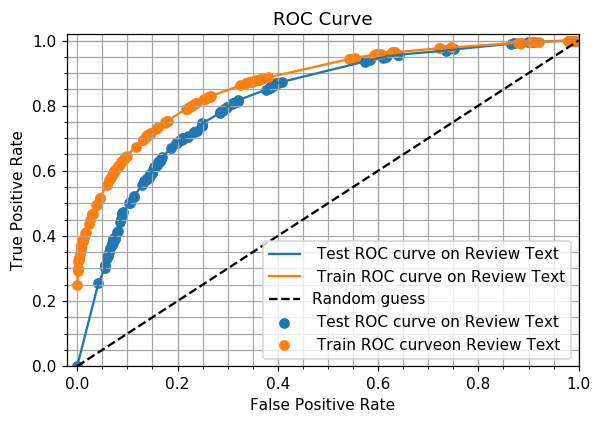

In [56]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_DT, tpr_test_tfidf_DT, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidf_DT)
fpr_train_tfidf_DT, tpr_train_tfidf_DT, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidf_DT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_DT, tpr_test_tfidf_DT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_DT, tpr_test_tfidf_DT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_DT, tpr_train_tfidf_DT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_DT, tpr_train_tfidf_DT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [57]:
from sklearn.metrics import roc_auc_score
predict_DT_tfidf_train = grid_DT_tfidf.predict(tfidf_X_train)
predict_DT_tfidf_test = grid_DT_tfidf.predict(tfidf_X_test)

roc_auc_DT_tfidf_train = roc_auc_score(y_test_40k, predict_DT_tfidf_test)
roc_auc_DT_tfidf_test = roc_auc_score(y_train_40k, predict_DT_tfidf_train)

In [58]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_DT_tfidf_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_DT_tfidf_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.37      0.74      0.49      2156
          1       0.94      0.75      0.83     11044

avg / total       0.84      0.75      0.78     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.44      0.84      0.58      4707
          1       0.96      0.77      0.85     22093

avg / total       0.87      0.78      0.80     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


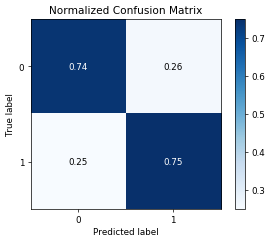

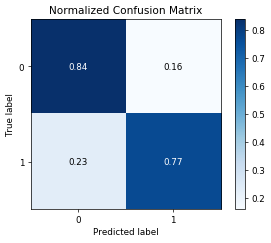

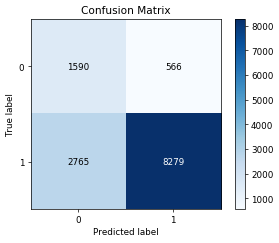

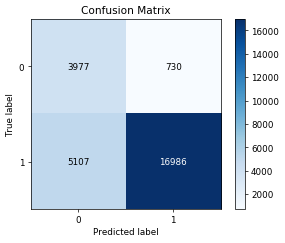

In [59]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_DT_tfidf_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_DT_tfidf_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_DT_tfidf_test)
skplt.plot_confusion_matrix(y_train_40k, predict_DT_tfidf_train)


### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [70]:
# https://github.com/Manish-12/Decision-Tree-on-Amazon-fine-food-reviews/blob/master/Decision_tree.ipynb
top_20_feature_tfidf = besthyperpara_tfidf_DT.feature_importances_.argsort()[::-1][:20]
below_20_feature_tfidf = besthyperpara_tfidf_DT.feature_importances_.argsort()[::-1][20:]

print(np.take(tf_idf_vect.get_feature_names(),top_20_feature_tfidf))

['not' 'great' 'best' 'perfect' 'love' 'good' 'disappointed' 'delicious'
 'bad' 'nice' 'money' 'highly recommend' 'excellent' 'loves' 'wonderful'
 'happy' 'easy' 'favorite' 'thought' 'reviews']


In [71]:
print(np.take(tf_idf_vect.get_feature_names(),below_20_feature_tfidf))

['little' 'tasty' 'lov' ... 'pineapple' 'pink' '10']


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [104]:
besthyperpara_tfidf_DT_depth5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=1000,class_weight='balanced')
besthyperpara_tfidf_DT_depth5.fit(tfidf_X_train,y_train_40k)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [105]:
#https://pythonprogramminglanguage.com/decision-tree-visual-example/

from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(besthyperpara_tfidf_DT_depth5,feature_names =tf_idf_vect.get_feature_names() ,out_file='tree_tfidf.dot')


In [106]:
from IPython.display import Image
Image(filename = r'C:\Users\Prateek Saurabh\AppliedAI\Homework and assignments\tree_tfidf.png')

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [61]:
lst_train=[]
lst_test=[]
lst_of_lst_train = []
lst_of_lst_test = []

for sentance in tqdm(X_no_stop_train_40k):
    lst_train.append(sentance.strip())
for sentance in tqdm(lst_train):
    lst_of_lst_train.append(sentance.split())

for sent in tqdm(X_no_stop_test_40k):
    lst_test.append(sent.strip())
for sent in tqdm(lst_test):
    lst_of_lst_test.append(sent.split())
    
    
w2v_model_self_taught_train=Word2Vec(lst_of_lst_train,min_count=1,size=50, workers=4)
w2v_words_train = list(w2v_model_self_taught_train.wv.vocab)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [00:00<00:00, 206522.70it/s]


In [62]:
sent_vectors_train = []
for sent1 in tqdm(lst_of_lst_train): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_train:
            vec1 = w2v_model_self_taught_train.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_train.append(sent_vec1) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26800/26800 [01:35<00:00, 280.59it/s]


In [63]:
sent_vectors_test = []
for sent2 in tqdm(lst_of_lst_test): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_train:
            vec2 = w2v_model_self_taught_train.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_test.append(sent_vec2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [01:02<00:00, 210.36it/s]


In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500,1000]}
grid_DT_avgw2v = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_DT_avgw2v.fit(sent_vectors_train,y_train_40k)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] m

[CV] ................... max_depth=50, min_samples_split=1000 -   0.6s
[CV] max_depth=50, min_samples_split=1000 ............................
[CV] ................... max_depth=50, min_samples_split=1000 -   0.5s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.0s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.0s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.1s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   1.1s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   1.1s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [65]:
grid_DT_avgw2v.best_params_

{'max_depth': 100, 'min_samples_split': 500}

In [66]:
besthyperpara_avgw2v_DT = DecisionTreeClassifier(max_depth=100,min_samples_split=500,class_weight='balanced')
besthyperpara_avgw2v_DT.fit(sent_vectors_train,y_train_40k)
pred_proba_train_avgw2v_DT=(besthyperpara_avgw2v_DT.predict_proba(sent_vectors_train)[:,1])
pred_proba_test_avgw2v_DT=(besthyperpara_avgw2v_DT.predict_proba(sent_vectors_test)[:,1])
roc_auc_test_avgw2v_DT_= (roc_auc_score(y_test_40k,pred_proba_test_avgw2v_DT))
roc_auc_train_avgw2v_DT  = (roc_auc_score(y_train_40k,pred_proba_train_avgw2v_DT))


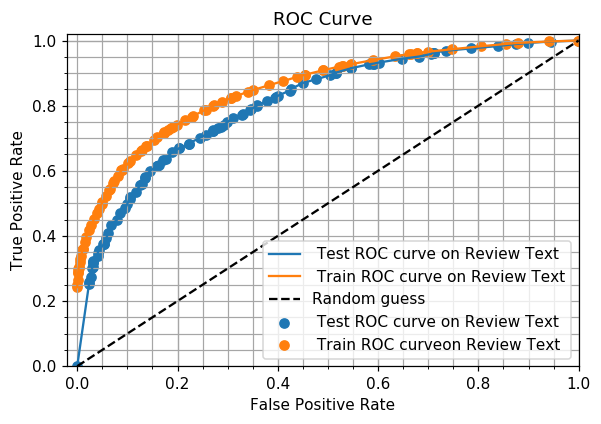

In [67]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgw2v_DT, tpr_test_avgw2v_DT, thresholds = roc_curve(y_test_40k,pred_proba_test_avgw2v_DT)
fpr_train_avgw2v_DT, tpr_train_avgw2v_DT, thresholds = roc_curve(y_train_40k,pred_proba_train_avgw2v_DT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgw2v_DT, tpr_test_avgw2v_DT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgw2v_DT, tpr_test_avgw2v_DT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_DT, tpr_train_avgw2v_DT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_DT, tpr_train_avgw2v_DT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [68]:
from sklearn.metrics import roc_auc_score
predict_DT_avgw2v_train = grid_DT_avgw2v.predict(sent_vectors_train)
predict_DT_avgw2v_test = grid_DT_avgw2v.predict(sent_vectors_test)


from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_DT_avgw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_DT_avgw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.34      0.72      0.46      2156
          1       0.93      0.73      0.82     11044

avg / total       0.83      0.73      0.76     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.39      0.82      0.53      4707
          1       0.95      0.72      0.82     22093

avg / total       0.85      0.74      0.77     26800



In [107]:
roc_auc_DT_avgw2v_train = roc_auc_score(y_test_40k, predict_DT_avgw2v_test)
roc_auc_DT_avgw2v_test = roc_auc_score(y_train_40k, predict_DT_avgw2v_train)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


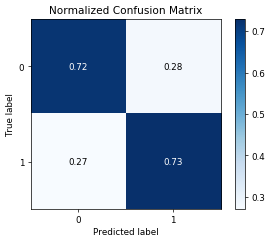

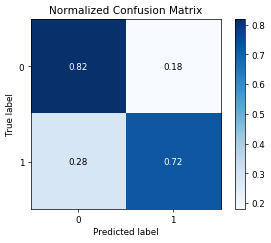

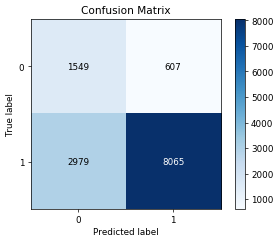

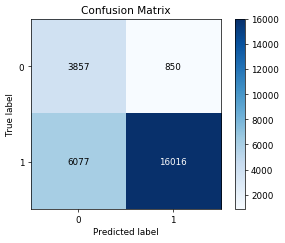

In [69]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_DT_avgw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_DT_avgw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_DT_avgw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_DT_avgw2v_train)


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
model_tfidfw2v = TfidfVectorizer()
model_tfidfw2v.fit(X_no_stop_train_40k)
dictionary = dict(zip(model_tfidfw2v.get_feature_names(), list(model_tfidfw2v.idf_)))
tfidf_feat_tfidfw2v = model_tfidfw2v.get_feature_names() 

In [82]:
tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train and word4 in tfidf_feat_tfidfw2v:
            vec4 = w2v_model_self_taught_train.wv[word4]
            tf_idf_train = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train)
            weight_sum4 += tf_idf_train
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_train.append(sent_vec4)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26800/26800 [10:28<00:00, 42.62it/s]


In [83]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train and word5 in tfidf_feat_tfidfw2v:
            vec5 = w2v_model_self_taught_train.wv[word5]
            tf_idf_test = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test)
            weight_sum5 += tf_idf_test
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_test.append(sent_vec5)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [04:51<00:00, 45.32it/s]


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500,1000]}
grid_DT_tfidfw2v = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_DT_tfidfw2v.fit(tfidf_w2v_sent_vectors_train,y_train_40k)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ....................... max_depth=1, min_samples_split=5 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ...................... max_depth=1, min_samples_split=10 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] max_depth=1, min_samples_split=100 ..............................
[CV] ..................... max_depth=1, min_samples_split=100 -   0.0s
[CV] m

[CV] ................... max_depth=50, min_samples_split=1000 -   0.6s
[CV] max_depth=50, min_samples_split=1000 ............................
[CV] ................... max_depth=50, min_samples_split=1000 -   0.5s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.1s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.1s
[CV] max_depth=100, min_samples_split=5 ..............................
[CV] ..................... max_depth=100, min_samples_split=5 -   1.0s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   1.0s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .................... max_depth=100, min_samples_split=10 -   1.0s
[CV] max_depth=100, min_samples_split=10 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [86]:
grid_DT_tfidfw2v.best_params_

{'max_depth': 500, 'min_samples_split': 500}

In [87]:
besthyperpara_tfidfw2v_DT = DecisionTreeClassifier(max_depth=500,min_samples_split=500,class_weight='balanced')
besthyperpara_tfidfw2v_DT.fit(tfidf_w2v_sent_vectors_train,y_train_40k)
pred_proba_train_tfidfw2v_DT=(besthyperpara_tfidfw2v_DT.predict_proba(tfidf_w2v_sent_vectors_train)[:,1])
pred_proba_test_tfidfw2v_DT=(besthyperpara_tfidfw2v_DT.predict_proba(tfidf_w2v_sent_vectors_test)[:,1])
roc_auc_test_tfidfw2v_DT_= (roc_auc_score(y_test_40k,pred_proba_test_tfidfw2v_DT))
roc_auc_train_tfidfw2v_DT  = (roc_auc_score(y_train_40k,pred_proba_train_tfidfw2v_DT))


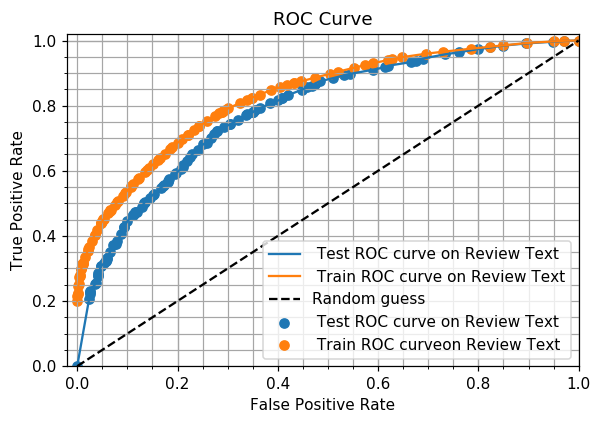

In [108]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_DT, tpr_test_tfidfw2v_DT, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidfw2v_DT)
fpr_train_tfidfw2v_DT, tpr_train_tfidfw2v_DT, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidfw2v_DT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_DT, tpr_test_tfidfw2v_DT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_DT, tpr_test_tfidfw2v_DT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_DT, tpr_train_tfidfw2v_DT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_DT, tpr_train_tfidfw2v_DT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [110]:
from sklearn.metrics import roc_auc_score
predict_DT_tfidfw2v_train = grid_DT_avgw2v.predict(tfidf_w2v_sent_vectors_train)
predict_DT_tfidfw2v_test = grid_DT_avgw2v.predict(tfidf_w2v_sent_vectors_test)


from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_DT_tfidfw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_DT_tfidfw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.31      0.70      0.43      2156
          1       0.92      0.69      0.79     11044

avg / total       0.82      0.70      0.73     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.32      0.70      0.44      4707
          1       0.91      0.68      0.78     22093

avg / total       0.81      0.68      0.72     26800



In [113]:
roc_auc_DT_tfidfw2v_train = roc_auc_score(y_test_40k, predict_DT_tfidfw2v_test)
roc_auc_DT_tfidfw2v_test = roc_auc_score(y_train_40k, predict_DT_tfidfw2v_train)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


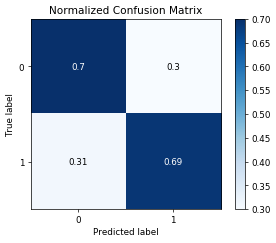

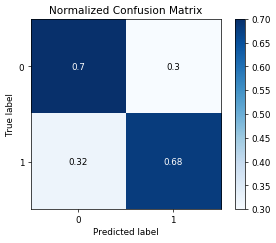

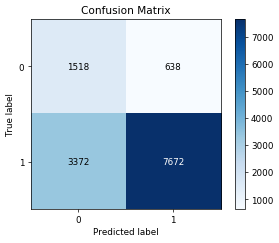

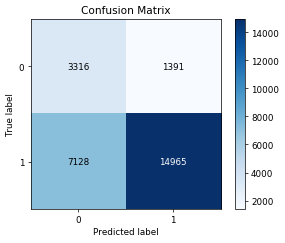

In [114]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_DT_tfidfw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_DT_tfidfw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_DT_tfidfw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_DT_tfidfw2v_train)


# [6] Conclusions

In [115]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Hyper-Parameter", "AUC"]

x.add_row(["Decision Tree BOW Test", "'max_depth': 50, 'min_samples_split': 1000",roc_auc_DT_BOW_test])
x.add_row(["Decision Tree BOW Train", "'max_depth': 50, 'min_samples_split': 1000",roc_auc_DT_BOW_train])
x.add_row(["Decision Tree TFIDF Test", "'max_depth': 50, 'min_samples_split': 1000" ,roc_auc_DT_tfidf_test])
x.add_row(["Decision Tree TFIDF Train", "'max_depth': 50, 'min_samples_split': 1000" ,roc_auc_DT_tfidf_train])
x.add_row(["Decision Tree AVGW2V Test","'max_depth': 100, 'min_samples_split': 500", roc_auc_DT_avgw2v_test])
x.add_row(["Decision Tree AVGW2V Train","'max_depth': 100, 'min_samples_split': 500",roc_auc_DT_avgw2v_train])
x.add_row(["Decision Tree TFIDF-W2V Test","'max_depth': 500, 'min_samples_split': 500", roc_auc_DT_tfidfw2v_test])
x.add_row(["Decision Tree TFIDF-W2V Train","'max_depth': 500, 'min_samples_split': 500",roc_auc_DT_tfidfw2v_train ])

print (x)


+-------------------------------+--------------------------------------------+--------------------+
|           Algorithm           |              Hyper-Parameter               |        AUC         |
+-------------------------------+--------------------------------------------+--------------------+
|     Decision Tree BOW Test    | 'max_depth': 50, 'min_samples_split': 1000 | 0.7921241560784951 |
|    Decision Tree BOW Train    | 'max_depth': 50, 'min_samples_split': 1000 | 0.7453423781682177 |
|    Decision Tree TFIDF Test   | 'max_depth': 50, 'min_samples_split': 1000 | 0.8068763213728366 |
|   Decision Tree TFIDF Train   | 'max_depth': 50, 'min_samples_split': 1000 | 0.7435573106460983 |
|   Decision Tree AVGW2V Test   | 'max_depth': 100, 'min_samples_split': 500 | 0.7721766940918228 |
|   Decision Tree AVGW2V Train  | 'max_depth': 100, 'min_samples_split': 500 | 0.7243604431993732 |
|  Decision Tree TFIDF-W2V Test | 'max_depth': 500, 'min_samples_split': 500 | 0.6909232781357821 |


1. Of all  the four algorithms TFIDF and BOW performed better than AVGW2V and TFIDFW2V specially considering the amount of time AVGW2V and TFIDFW2V i personally would rate BOW and TFIDF much better
